In [1]:
%%capture
%load_ext autoreload
%autoreload 2
# %cd ..
import sys
sys.path.append("..")
import statnlpbook.util as util
util.execute_notebook('language_models.ipynb')
# import tikzmagic
%load_ext tikzmagic
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\prob}{p}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
$$

In [2]:
from IPython.display import Image
import random

In [3]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# Language Modelling


## Language Models

calculate the **probability of seeing a sequence of words**. 

What is the most likely next word?

> We're going to ...

How about now?

> We're going to win ...

How likely is this sequence?

> We're going to win bigly. 

Is it more likely than this one?

> We're going to win big league.

## Use Cases: Machine Translation

> Vi skal vinne stort

translates to?

> We will win by a mile

or 

> We will win bigly

## Use Cases: Speech Recognition

What did he [say](https://www.theguardian.com/us-news/video/2016/may/04/donald-trump-we-are-going-to-win-bigly-believe-me-video)?

> We're going to win bigly

or

> We're going to win big league

## Use Cases: Natural Language Generation

<img src="../img/drumpf.png">

https://twitter.com/deepdrumpf

Other applications of language models?

## Outlook: Importance of Language Models

- State of the art NLP models utilise **transfer learning**
- Good (neural) language models are excellent starting points for transfer learning
     * Step 1: unsupervised language model **pre-training**
     * Step 2: supervised language model **fine-tuning**

## Outlook: How to build good language models?

- Train them on large datasets
- Use a large number of features/parameters

... but first, the basics

## Overview

* Language Modelling from scratch
* Evaluation
* Dealing with Out-Of-Vocabulary words (OOVs)
* Training
* Smoothing

## Formally
Models the probability 

$$\prob(w_1,\ldots,w_d)$$ 

of observing sequences of words \\(w_1,\ldots,w_d\\). 

Without loss of generality: 

\begin{align}
\prob(w_1,\ldots,w_d) &= p(w_1) p(w_2|w_1) p(w_3|w_1, w_2) \ldots \\
 &= \prob(w_1) \prod_{i = 2}^d \prob(w_i|w_1,\ldots,w_{i-1})
\end{align}

### Structured Prediction

predict word $y=w_i$ 
* conditioned on history $\x=w_1,\ldots,w_{i-1}$.

## N-Gram Language Models

Impossible to estimate sensible probability for each history 

$$
\x=w_1,\ldots,w_{i-1}
$$

### Change **representation**
truncate history to last $n-1$ words: 

$$
\mathbf{f}(\x)=w_{i-(n-1)},\ldots,w_{i-1}
$$

$\prob(\text{bigly}|\text{...,blah, blah, blah, we, will, win}) 
= \prob(\text{bigly}|\text{we, will, win})$

### Unigram LM

Set $n=1$:
$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i).
$$

$\prob(\text{bigly}|\text{we, will, win}) = \prob(\text{bigly})$

### Bigram LM

Set $n=2$:
$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i|w_{i-1}).
$$

$\prob(\text{bigly}|\text{we, will, win}) = \prob(\text{bigly}|\text{win})$

### *Uniform* LM
Set $n=0$:

Same probability for each word in the vocabulary \\(\vocab\\):

$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \frac{1}{|\vocab|}.
$$

$\prob(\text{big}) = \prob(\text{bigly}) = \frac{1}{|\vocab|}$

Let us look at a training set and create a uniform LM from it.

In [6]:
train[:9]

['Can', "'t", 'even', 'call', 'this', 'a', 'blues', 'song', 'It']

In [7]:
vocab = set(train)
baseline = UniformLM(vocab)
sum([baseline.probability(w) for w in vocab])

0.9999999999999635

What about words outside the vocabulary? What is their probability?

## Sampling
* Sampling from an LM is easy and instructive
* Usually, the better the LM, the better the samples

Sample **incrementally**, one word at a time 

In [8]:
def sample_once(lm, history, words):
    probs = [lm.probability(word, *history) for word in words]
    return np.random.choice(words,p=probs)

In [9]:
sample_once(baseline, [], list(baseline.vocab))    

'sunrise'

In [10]:
def sample(lm, initial_history, amount_to_sample):
    words = list(lm.vocab)
    result = []
    result += initial_history
    for _ in range(0, amount_to_sample):
        history = result[-(lm.order - 1):]
        result.append(sample_once(lm,history,words))
    return result

In [33]:
sample(baseline, [], 10)

['dummies',
 'find',
 'being',
 'bars',
 'clap',
 'rapping',
 'droppin',
 'fender',
 'hated',
 'Recognize']

## Evaluation
* **Extrinsic**: how does it improve a downstream task?
* **Intrinsic**: how well does it model language?

## Intrinsic Evaluation
**Shannon Game**: Predict next word, win if prediction matches the word in actual corpus

> Our horrible trade agreements with [???]

The expected reward is the probability of the corpus.

Formalised by

\begin{align}
\prob(w_1) \prob(w_2|w_1) \ldots \prob(w_T|w_1,\ldots,w_{T-1}) &= \prod_{i=1}^T \prob(w_i|w_1,\ldots,w_{i-1})
\end{align}

But then the longer the sequence, the lower the probability...

$\to$ normalise by the length

### Perplexity 
Given test sequence \\(w_1,\ldots,w_T\\), perplexity \\(\perplexity\\) is **geometric mean of inverse probabilities** or, put differently the **inverse probability of the test set, normalised by the number of words**:

\begin{align}
\perplexity(w_1,\ldots,w_T) &= \sqrt[T]{\frac{1}{\prob(w_1)} \frac{1}{\prob(w_2|w_1)} \ldots} \\
&= \sqrt[T]{\prod_i^T \frac{1}{\prob(w_i|w_1,\ldots,w_{i-1})}}
\end{align}

Perplexity for a bigram language model:

\begin{align}
\perplexity(w_1,\ldots,w_T) &= \sqrt[T]{\prod_i^T \frac{1}{\prob(w_i|w_{i-1})}}
\end{align}

Perplexity for a unigram language model:

\begin{align}
\perplexity(w_1,\ldots,w_T) &= \sqrt[T]{\prod_i^T \frac{1}{\prob(w_i)}}
\end{align}

Perplexity for a uniform language model:

\begin{align}
\perplexity(w_1,\ldots,w_T) &= \sqrt[T]{\prod_i^T \frac{1}{1/|V|}} = |V|
\end{align}

### Brief note on inverse functions

- $T$ is the number of words under consideration, e.g. for bigram language models, it is 2.
- For simplicity, assume $a = \frac{1}{p(w_1, ... w_T)}$
- $\sqrt[T]{a}$ is the inverse function of $a^T$
- Meaning, we are looking for a number for the Perplexity $PP$, which, when multiplied with itself $T$ times, results in $a$

### Interpretation

Consider LM where 
* at each position there are exactly **2** possible words with $\frac{1}{2}$ probability each
* in test sequence, one of these is always the true word 

Then 

* $\perplexity(w_1,\ldots,w_T) = \sqrt[T]{2 \cdot 2  \cdot\ldots} = 2$
* Whenever a model has to guess the next word, it is confused as to which one the 2 to pick
* Perplexity $\approx$ average number of choices
* The lower the number of average choice, i.e. the lower the Perplexity, the better

Perplexity of uniform LM on an **unseen** test set?

In [12]:
perplexity(baseline, test)

inf

Problem: model assigns **zero probability** to words not in the vocabulary. 

In [13]:
[(w,baseline.probability(w)) for w in test if w not in vocab][:5]

[('does', 0.0),
 ('Ceremonies', 0.0),
 ('Masquerading', 0.0),
 ('also', 0.0),
 ('Creativity', 0.0)]

## The Long Tail
New words not specific to our corpus: 
* long **tail** of words that appear only a few times
* each individual one has low probability, but probability of seeing any long tail word is high


Let us plot word frequency ranks (x-axis) against frequency (y-axis) 

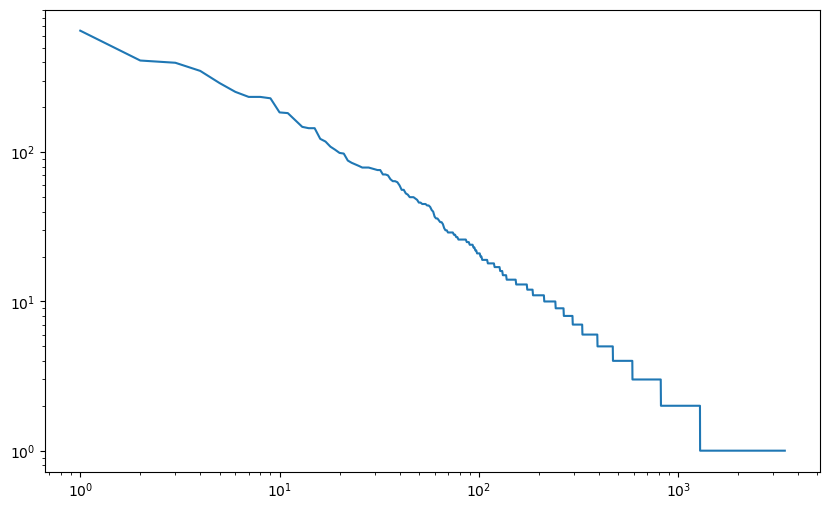

In [14]:
plt.xscale('log')
plt.yscale('log') 
plt.plot(ranks, sorted_counts)

In log-space such rank vs frequency graphs are **linear** 

* Known as **Zipf's Law**

Let $r_w$ be the rank of a word \\(w\\), and \\(f_w\\) its frequency:

$$
  f_w \propto \frac{1}{r_w}.
$$

## Out-of-Vocabularly (OOV) Tokens
In your test set, there will virtually always be words with zero training counts.

Why is this a problem?

* If probability of a word in the test set is 0, the entire probability of the test set is 0
    * Perplexity is based on inverse probability of test set
    * Since we cannot divide by 0, we cannot compute perplexity at all at this point
* Underestimating probability of unseen words
    * Downstream application performance suffers

Solutions:
1. Remove unseen words from test set (pretend there is no problem)?
2. Use subword tokenisation to ensure there are no `OOV` tokens?
3. **Replace unseen words with out-of-vocabularly token, estimate its probability (`OOV` injection)?**
4. Move probability mass to unseen words (smoothing)?

### `OOV` Injection Procedures

* For the test set: mark all words not in the training vocabulary as `OOV`
* For the training set: when a word occurs for the first time, mark it as `OOV`

### Replacing Words with OOV Tokens

In [15]:
print(test[60:100])

# Replace every word not within the vocabulary with the `OOV` symbol
# [word if word in vocab else OOV for word in data]
print(replace_OOVs(baseline.vocab, test[60:100]))

['with', 'the', 'lyrics', 'of', 'the', 'year', 'Than', 'the', 'gimmick', 'with', 'the', 'gear', 'and', 'the', 'right', 'puppeteer', 'Now', 'you', 'can', 'be', 'the', 'next', 'rock', 'Shakespear', 'you', "'", 're', 'still', '10', 'steps', 'away', 'from', 'having', 'a', 'career', 'You', 'step', 'up', 'the', 'plate']
['with', 'the', 'lyrics', 'of', 'the', '[OOV]', '[OOV]', 'the', '[OOV]', 'with', 'the', '[OOV]', 'and', 'the', 'right', '[OOV]', 'Now', 'you', 'can', 'be', 'the', 'next', 'rock', '[OOV]', 'you', "'", 're', 'still', '10', 'steps', 'away', 'from', '[OOV]', 'a', 'career', 'You', '[OOV]', 'up', 'the', 'plate']


### Injecting OOV Tokens for New Word Events

Consider the "words"

> AA AA BB BB AA

Going left to right, how often do I see new words?

Inject `OOV` tokens to mark these "new word events"

In [16]:
inject_OOVs(["AA","AA","BB","BB","AA"])

['[OOV]', 'AA', '[OOV]', 'BB', 'AA']

### Estimate `OOV` Probability
What is the probability of seeing a word you haven't seen before?

Train on replaced data...

In [17]:
oov_train = inject_OOVs(train)
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, test)
oov_baseline = UniformLM(oov_vocab)
perplexity(oov_baseline,oov_test)

1287.9999999984573

<center><img src="../img/quiz_time.png"></center>


## [tinyurl.com/diku-nlp-oov](https://tinyurl.com/diku-nlp-oov)

([Responses](https://docs.google.com/forms/d/1D9p_ej-puRhwGEl_P-h9RWxwvW9KK427qx63-9NB-20/edit#responses))

### `OOV` and Perplexity

* LM can achieve low perplexity by choosing small vocabulary and assigning high probability to unknown words
    * Perplexities are vocabulary-dependent

## Training N-Gram Language Models

N-gram language models condition on a limited history: 

$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i|w_{i-(n-1)},\ldots,w_{i-1}).
$$

What are its parameters (continuous values that control its behaviour)?

One parameter $\param_{w,h}$ for each word $w$ and history $h=w_{i-(n-1)},\ldots,w_{i-1}$ pair:

$$
\prob_\params(w|h) = \param_{w,h}
$$

$\prob_\params(\text{bigly}|\text{win}) = \param_{\text{bigly, win}}$

### Maximum Likelihood Estimate

Assume training set \\(\train=(w_1,\ldots,w_d)\\)

Find \\(\params\\) that maximises the log-likelihood of \\(\train\\):

$$
\params^* = \argmax_\params \log p_\params(\train)
$$

where

$$
\prob_\params(\train) = \ldots \prob_\params(w_i|\ldots w_{i-1}) \prob_\params(w_{i+1}|\ldots w_{i}) \ldots 
$$

**Structured Prediction**: this is your continuous optimisation problem!

Maximum-log-likelihood estimate (MLE) can be calculated in **closed form**:
$$
\prob_{\params^*}(w|h) = \param^*_{w,h} = \frac{\counts{\train}{h,w}}{\counts{\train}{h}} 
$$

where 

$$
\counts{D}{e} = \text{Count of } e \text{ in }  D 
$$

Event $h$ means seeing the history $h$, and $w,h$ seeing the history $h$ followed by word $w$.  

Many LM variants: different estimation of counts. 

## Training a Unigram Model
Let us train a unigram model...

What do you think the most probable words are? 

Remember our training set looks like this ...

In [18]:
oov_train[1000:1010]

['bird', 'I', 'know', 'this', '[OOV]', '[OOV]', '[OOV]', 'is', 'this', '[OOV]']

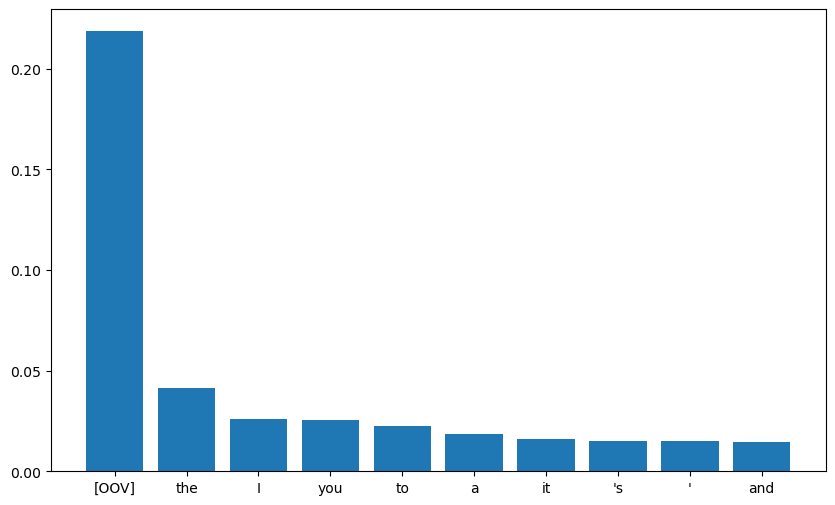

In [19]:
unigram = NGramLM(oov_train,1)
plot_probabilities(unigram)
# sum([unigram.probability(w) for w in unigram.vocab])

The unigram LM has substantially reduced (and hence better) perplexity than the uniform LM:

In [20]:
perplexity(oov_baseline,oov_test), perplexity(unigram,oov_test)

(1287.9999999984573, 128.9093846843014)

Its samples look (a little) more reasonable:

In [21]:
print(sample(oov_baseline, [], 10), "\n")
print(sample(unigram, [], 10))

['hands', 'play', 'below', 'never', 'around', 'type', 'grows', 'about', 'debate', 'himself'] 

['the', '[OOV]', 'to', 'in', 'Singing', '[OOV]', '[OOV]', "'m", 'live', 'to']


## Bigram Model
We can do better by setting $n=2$

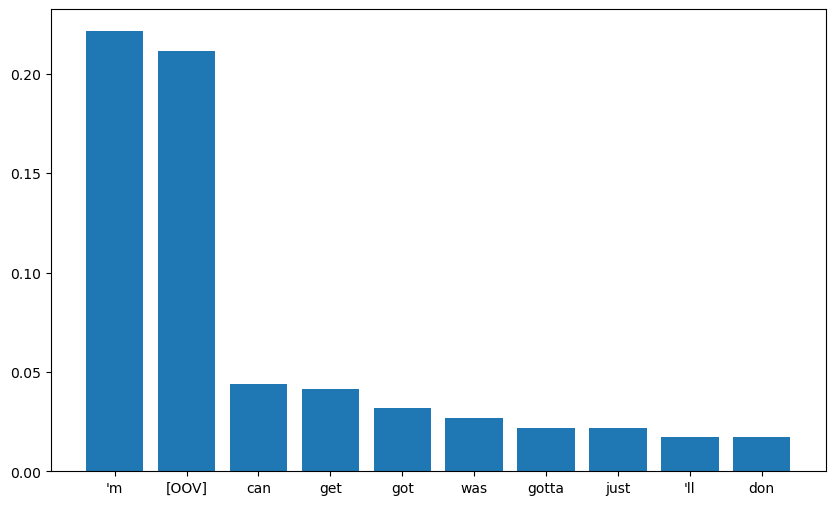

In [22]:
bigram = NGramLM(oov_train,2)
plot_probabilities(bigram, ("I",)) # bigrams starting with "I"

Samples should look (slightly) more fluent:

In [23]:
" ".join(sample(bigram, ['I'], 30)) # try: I, FIND, [OOV]

"I set em Yo [OOV] enemies [OOV] [OOV] is yours what the [OOV] it So it There 's mind [OOV] Recognize your [OOV] up [OOV] [OOV] wanna get up [OOV] and"

How about perplexity?

In [24]:
perplexity(bigram,oov_test)

inf

Some contexts where OOV word (and others) haven't been seen, hence 0 probability...

In [25]:
bigram.probability("[OOV]","money")

0.0

## Out-of-Vocabularly (OOV) Tokens
In your test set, there will virtually always be words with zero training counts.

Solutions:
1. Remove unseen words from test set (pretend there is no problem)?
2. Use subword tokenisation to ensure there are no `OOV` tokens?
3. Replace unseen words with out-of-vocabularly token, estimate its probability (`OOV` injection)?
4. **Move probability mass to unseen words (smoothing)?**

## Smoothing

Maximum likelihood 
* **underestimates** true probability of some words 
* **overestimates** the probabilities of other

Solution: _smooth_ the probabilities and **move mass** from seen to unseen events.

### Laplace Smoothing / Additive Smoothing

Add **pseudo counts** to each event in the dataset 

$$
\param^{\alpha}_{w,h} = \frac{\counts{\train}{h,w} + \alpha}{\counts{\train}{h} + \alpha \lvert V \rvert } 
$$

In [26]:
laplace_bigram = LaplaceLM(bigram, 0.1) 
laplace_bigram.probability("[OOV]","money")

0.0007704160246533128

Perplexity should look better now:

In [27]:
perplexity(LaplaceLM(bigram, 0.001),oov_test)

255.11837473847797

### Example
Consider three events:

In [28]:
c  = ["word",         "train count", "MLE",  "Laplace", "Same Denominator"]
r1 = ["smally",       "0",           "0/3",    "1/6",       "0.5/3"]
r2 = ["bigly",        "1",           "1/3",    "2/6",       "1/3"]
r3 = ["tremendously", "2",           "2/3",    "3/6",       "1.5/3"]
util.Table([r1,r2,r3], column_names=c)

word,train count,MLE,Laplace,Same Denominator
smally,0,0/3,1/6,0.5/3
bigly,1,1/3,2/6,1/3
tremendously,2,2/3,3/6,1.5/3


### Interpolation / Jelinek-Mercer Smoothing
* Laplace Smoothing assigns mass **uniformly** to the words that haven't been seen in a context.

In [29]:
laplace_bigram.probability('rhyme','man'), \
laplace_bigram.probability('of','man') 
# also try: 'skies','skies' vs. '[/BAR]','skies'

(0.0005656108597285067, 0.0005656108597285067)

Problem: not all unseen words (in a context) are equal

With **interpolation** we can do better: 
* give more mass to words likely under the $n-1$-gram model. 
    * Use $\prob(\text{of})$ for estimating $\prob(\text{of} | \text{man})$

* Combine $n$-gram model \\(p'\\) and a back-off \\(n-1\\) model \\(p''\\): 

$$
\prob_{\alpha}(w_i|w_{i-n+1},\ldots,w_{i-1}) = \alpha \cdot \prob'(w_i|w_{i-n+1},\ldots,w_{i-1}) + \\ (1 - \alpha) \cdot \prob''(w_i|w_{i-n+2},\ldots,w_{i-1})
$$


In [30]:
interpolated = InterpolatedLM(bigram,unigram,0.01)
interpolated.probability('rhyme','man'), \
interpolated.probability('of','man')

(0.0014514278429372768, 0.009276517083120857)

Can we find a good $\alpha$ parameter? Tune on some **development set**!

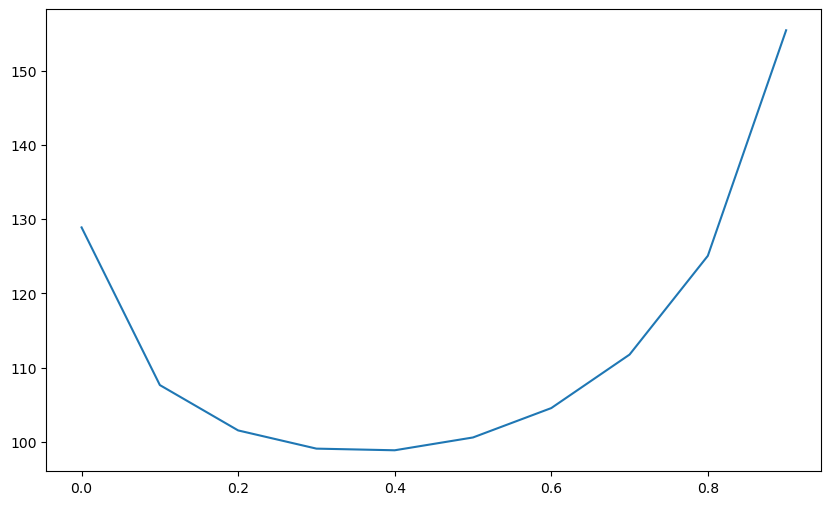

In [31]:
alphas = np.arange(0,1.1,0.1)
perplexities = [perplexity(InterpolatedLM(bigram,unigram,alpha),oov_test) 
                for alpha in alphas]
plt.plot(alphas,perplexities)

### Backoff 
* When we have counts for an event, trust these counts and not the simpler model
    * use $\prob(\text{bigly}|\text{win})$ if you have seen $(\text{win, bigly})$, not $\prob(\text{bigly})$
* **back-off** only when no counts for a given event are available.

### Stupid Backoff
Let \\(w\\) be a word and \\(h_{m}\\) an n-gram of length \\(m\\):  

$$
\prob_{\mbox{Stupid}}(w|h_{m}) = 
\begin{cases}
\frac{\counts{\train}{h_{m},w}}{\counts{\train}{h_{m}}}  &= \mbox{if }\counts{\train}{h_{m},w} > 0 \\\\
\prob_{\mbox{Stupid}}(w|h_{m-1}) & \mbox{otherwise}
\end{cases}
$$

What is the problem with this model?

In [32]:
stupid = StupidBackoff(bigram, unigram, 0.1)
sum([stupid.probability(word, 'the') for word in stupid.vocab])

1.0684727180010114

Discuss with your neighbour and enter your answer here:
## [tinyurl.com/diku-nlp-backoff](https://tinyurl.com/diku-nlp-backoff)
([Responses](https://docs.google.com/forms/d/1UMmtDqpzf7pXxWqqsgK7pH3sA5EVXXWzfRaXHe9LICM/edit#responses))

### Solution

The score is not a probability distribution (probabilities do not sum to 1). Sampling thus requires further normalisation.

### Exercise

How can we check whether a language model provides a valid probability distribution? Solve [Task 2](../exercises/language_models.ipynb).

### Absolute Discounting
Recall that in test data, a constant probability mass is taken away for each non-zero count event. Can this be captured in a smoothing algorithm?

Yes: subtract (tunable) constant $d$ from each non-zero probability:

$$
\prob_{\mbox{Absolute}}(w|h_{m}) = 
\begin{cases}
\frac{\counts{\train}{h_{m},w}-d}{\counts{\train}{h_{m}}}   &= \mbox{if }\counts{\train}{h_{m},w} > 0 \\\\
\alpha(h_{m-1})\cdot\prob_{\mbox{Absolute}}(w|h_{m-1}) & \mbox{otherwise}
\end{cases}
$$

$\alpha(h_{m-1})$ is a normaliser

### Unigram Backoff

Assume, for example:
* *Mos Def* is a rapper name that appears often in the data
* *glasses* appears slightly less often
* neither *Def* nor *glasses* have been seen in the context of the word *reading*

Then the final-backoff unigram model might assign a higher probability to

> I can't see without my reading Def

than

> I can't see without my reading glasses

because $\prob(\text{Def}) > \prob(\text{glasses})$

But *Def* never follows anything but *Mos*, and we can determine this by looking at the training data!

### Kneser Ney Smoothing

Absolute Discounting, but as final backoff probability, use the probability that a word appears after (any) word in the training set: 

$$
\prob_{\mbox{KN}}(w) = \frac{\left|\{w_{-1}:\counts{\train}{w_{-1},w}> 1\}  \right|}
{\sum_{w'}\left|\{w_{-1}:\counts{\train}{w_{-1},w'}\} > 1 \right|}  
$$

This is the *continuation probability*

### Modified Kneser Ney Smoothing

Rather than using a single discount $d$:
    use three different discounts $d_1$, $d_2$, $d_3$
    for 1-grams, 2-grams and n-grams with count 3 or more

See [Chen and Goodman 1998, p. 19](https://dash.harvard.edu/bitstream/handle/1/25104739/tr-10-98.pdf?sequence=1)

### Interpolation vs. Backoff

* Both combine information from higher- and lower-order models, e.g. 2-gram and 1-gram
* Both use lower-order models to determine probability of n-grams with zero counts
* Difference: 
    * Interpolated models use lower-order models also for n-grams with **non-zero** counts
    * Backoff models only do it for n-grams with **zero** counts

## Summary

* LMs model probability of sequences of words 
* Defined in terms of "next-word" distributions conditioned on history
* N-gram models truncate history representation
* Often trained by maximising log-likelihood of training data and ...
* smoothing to deal with sparsity

## Background Reading

* Jurafsky & Martin, [Speech and Language Processing (Third Edition)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf): Chapter 3, N-Gram Language Models.
* Bill MacCartney, Stanford NLP Lunch Tutorial: [Smoothing](http://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf)
* Chen, Stanley F. and Joshua Goodman. 1998. [An Empirical Study of Smoothing Techniques for Language Modeling.](https://dash.harvard.edu/bitstream/handle/1/25104739/tr-10-98.pdf?sequence=1) Harvard Computer Science Group Technical Report TR-10-98.
* [Sampling from language models](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277), a practical guide
* [Interpretation of Perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)